# 尝试反向建模生成制备参数

In [22]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

In [23]:
current_directory = os.getcwd()
print(current_directory)
device=torch.device("cuda")
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/home/redfu/work/PINN/MFNN/singlefluid
Using GPU: NVIDIA GeForce RTX 2080 Ti


In [24]:
# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 读取 Excel 文件中的所有 sheet
url_hf = 'Data/DifferComponent_data.xlsm'
df_HF = pd.read_excel(url_hf, sheet_name=None)

# 初始化存储训练集和测试集的列表
train_inputs = []  # 存储训练集的 AngFreq 和 lossF
train_labels = []  # 存储训练集的 Mn1, Mn2, Mn3, Mn11, Mn22, Mn33
train_sequence_lengths = []  # 存储训练集的序列长度

test_inputs = []  # 存储测试集的 AngFreq 和 lossF
test_labels = []  # 存储测试集的 Mn1, Mn2, Mn3, Mn11, Mn22, Mn33
test_sequence_lengths = []  # 存储测试集的序列长度

# 遍历所有 sheet
for sheet_name, df in df_HF.items():
    # 移除包含 NaN 的行
    df = df.dropna()
    
    # 提取 AngFreq 和 lossF 作为输入特征
    ang_freq = df['AngFreq'].values.astype(np.float32)
    loss_f = df['lossF'].values.astype(np.float32)
    
    # 对 AngFreq 进行对数化处理
    ang_freq_log = np.log10(ang_freq)  # 使用 log10，也可以使用自然对数 np.log
    
    # 合并为 (N, 2) 的数组
    input_feature = np.column_stack((ang_freq_log, loss_f))
    
    # 提取 Mn1, Mn2, Mn3, Mn11, Mn22, Mn33 作为标签（只取第一行）
    label = df[['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33']].iloc[0].values.astype(np.float32)
    
    # 将 Mn11, Mn22, Mn33 乘以 100
    label[3:] *= 100  # Mn11, Mn22, Mn33 是标签的后三项
    
    # 根据sheet_name分配到训练集或测试集
    if sheet_name == 'b4':
        test_inputs.append(input_feature)
        test_labels.append(label)
        test_sequence_lengths.append(len(input_feature))
    else:
        train_inputs.append(input_feature)
        train_labels.append(label)
        train_sequence_lengths.append(len(input_feature))

# 对训练集输入特征进行归一化
input_scaler = MinMaxScaler()
# 首先用训练数据拟合归一化器
all_train_data = np.vstack(train_inputs)
input_scaler.fit(all_train_data)

# 然后分别对训练集和测试集进行转换
train_inputs_normalized = [input_scaler.transform(x) for x in train_inputs]
test_inputs_normalized = [input_scaler.transform(x) for x in test_inputs]

# 对标签进行归一化
label_scaler = MinMaxScaler()
# 用训练集标签拟合归一化器
label_scaler.fit(np.array(train_labels))

# 然后分别对训练集和测试集标签进行转换
train_labels_normalized = label_scaler.transform(np.array(train_labels))
test_labels_normalized = label_scaler.transform(np.array(test_labels))

# 将输入和标签转换为 PyTorch 张量
train_inputs_tensor = [torch.tensor(x, dtype=torch.float32) for x in train_inputs_normalized]
train_labels_tensor = torch.tensor(train_labels_normalized, dtype=torch.float32)
train_sequence_lengths = torch.tensor(train_sequence_lengths, dtype=torch.long)

test_inputs_tensor = [torch.tensor(x, dtype=torch.float32) for x in test_inputs_normalized]
test_labels_tensor = torch.tensor(test_labels_normalized, dtype=torch.float32)
test_sequence_lengths = torch.tensor(test_sequence_lengths, dtype=torch.long)

# 对变长序列进行填充
train_inputs_padded = pad_sequence(train_inputs_tensor, batch_first=True)
test_inputs_padded = pad_sequence(test_inputs_tensor, batch_first=True)


In [25]:


# 创建训练数据集
train_dataset = TensorDataset(train_inputs_padded, train_labels_tensor, train_sequence_lengths)

# 创建测试数据集
test_dataset = TensorDataset(test_inputs_padded, test_labels_tensor, test_sequence_lengths)

# 创建训练和测试 DataLoader
batch_size = 2  # 根据需求调整
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:

class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, label_dim):
        super(CVAE, self).__init__()
        self.input_dim = input_dim  #   输入特征维度（2）
        self.hidden_dim = hidden_dim  # GRU 隐藏层维度
        self.latent_dim = latent_dim  # 潜在空间维度
        self.label_dim = label_dim  # 标签维度（6）

        # 编码器（GRU）
        self.encoder_gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # 潜在空间均值
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 潜在空间对数方差

        # 解码器（全连接层）
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, label_dim)  # 输出标签
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # 编码器
        _, h_n = self.encoder_gru(x)  # GRU 输出最后一个时间步的隐藏状态
        h_n = h_n.squeeze(0)  # 去除多余的维度 (1, batch_size, hidden_dim) -> (batch_size, hidden_dim)

        # 计算潜在空间的均值和方差
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)

        # 重参数化
        z = self.reparameterize(mu, logvar)

        # 解码器
        labels_pred = self.decoder_fc(z)  # 生成标签

        return labels_pred, mu, logvar

In [27]:
# 初始化模型
input_dim = 2  # AngFreq 和 lossF
hidden_dim = 4  # 隐藏层维度
latent_dim = 10  # 潜在空间维度
label_dim = 6  # 标签维度（Mn1, Mn2, Mn3, Mn11, Mn22, Mn33）
model = CVAE(input_dim, hidden_dim, latent_dim, label_dim)  # 使用修改后的 CVAE 模型

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# 定义损失函数
def loss_function(labels_pred, labels, mu, logvar):
    # 重构损失（MSE）
    recon_loss = nn.functional.mse_loss(labels_pred, labels, reduction='sum')
    # KL 散度
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # 总损失
    total_loss = recon_loss + kl_div
    return total_loss, recon_loss, kl_div

# 训练
num_epochs = 1001  # 训练轮数
loss_history = []  # 记录损失
recon_loss_history = []  # 记录重构损失
kl_loss_history = []  # 记录 KL 散度

for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    epoch_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    for batch in train_dataloader:
        inputs, labels, lengths = batch  # 获取数据
        optimizer.zero_grad()  # 清空梯度

        # 前向传播
        labels_pred, mu, logvar = model(inputs)  # 生成标签

        # 计算损失
        loss, recon_loss, kl_loss = loss_function(labels_pred, labels, mu, logvar)

        # 反向传播
        loss.backward()
        optimizer.step()

        # 累加损失
        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

    # 记录损失
    loss_history.append(epoch_loss / len(train_dataloader.dataset))
    recon_loss_history.append(epoch_recon_loss / len(train_dataloader.dataset))
    kl_loss_history.append(epoch_kl_loss / len(train_dataloader.dataset))

    # 打印损失
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Total Loss: {loss_history[-1]:.4f}, '
              f'Recon Loss: {recon_loss_history[-1]:.4f}, '
              f'KL Loss: {kl_loss_history[-1]:.4f}')




Epoch [1/1001], Total Loss: 2.5002, Recon Loss: 1.9921, KL Loss: 0.5081
Epoch [11/1001], Total Loss: 2.6579, Recon Loss: 2.1512, KL Loss: 0.5067
Epoch [21/1001], Total Loss: 3.2430, Recon Loss: 2.7376, KL Loss: 0.5054
Epoch [31/1001], Total Loss: 2.7388, Recon Loss: 2.2348, KL Loss: 0.5041
Epoch [41/1001], Total Loss: 2.7221, Recon Loss: 2.2194, KL Loss: 0.5027
Epoch [51/1001], Total Loss: 2.9731, Recon Loss: 2.4717, KL Loss: 0.5014
Epoch [61/1001], Total Loss: 2.7014, Recon Loss: 2.2014, KL Loss: 0.5001
Epoch [71/1001], Total Loss: 2.9849, Recon Loss: 2.4862, KL Loss: 0.4988
Epoch [81/1001], Total Loss: 2.6992, Recon Loss: 2.2017, KL Loss: 0.4975
Epoch [91/1001], Total Loss: 2.3270, Recon Loss: 1.8308, KL Loss: 0.4962
Epoch [101/1001], Total Loss: 2.4330, Recon Loss: 1.9381, KL Loss: 0.4949
Epoch [111/1001], Total Loss: 3.5482, Recon Loss: 3.0547, KL Loss: 0.4936
Epoch [121/1001], Total Loss: 2.7053, Recon Loss: 2.2130, KL Loss: 0.4923
Epoch [131/1001], Total Loss: 3.3090, Recon Loss:

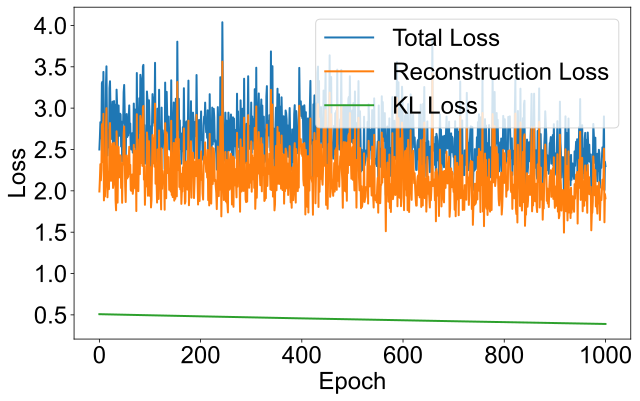

In [28]:
# 绘制损失曲线
plt.figure(figsize=(10, 6),dpi=300)

# 绘制曲线
plt.plot(loss_history, label='Total Loss', linewidth=2)
plt.plot(recon_loss_history, label='Reconstruction Loss', linewidth=2)
plt.plot(kl_loss_history, label='KL Loss', linewidth=2)

# 设置横纵坐标标签
plt.xlabel('Epoch', fontsize=24)  # 横坐标标签
plt.ylabel('Loss', fontsize=24)    # 纵坐标标签

# 设置横纵坐标刻度
plt.xticks(fontsize=24)  # 横坐标刻度字体大小
plt.yticks(fontsize=24)  # 纵坐标刻度字体大小

# 设置图例
plt.legend(fontsize=24, loc='upper right')  # 图例字体大小和位置


# 显示图像
plt.show()

## 根据训练好的CVAE进行模型生成

In [29]:
# 使用训练好的模型生成数据
model.eval()  # 设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        inputs, labels, lengths = batch  # 获取数据

        # 打印真实标签（反归一化）
        real_labels = label_scaler.inverse_transform(labels.numpy())  # 反归一化
        print("Real labels for this sequence:")
        print(real_labels)  # 打印真实标签

        # 生成 100 个标签数组
        for i in range(10):
            labels_pred, _, _ = model(inputs)  # 生成标签
            generated_labels = label_scaler.inverse_transform(labels_pred.numpy())  # 反归一化
            print(f"Generated labels {i+1}:")
            print(generated_labels)  # 打印生成的标签

        break  # 只处理第一个批次的数据（可以根据需要移除）

Real labels for this sequence:
[[20.3      52.2      78.3      10.       20.       30.000002]]
Generated labels 1:
[[ 16.461258    65.672646   -14.237544    19.556412     0.10481894
   -2.7420645 ]]
Generated labels 2:
[[13.1474    64.8        1.0055751 19.153673  -5.8993087 -4.582678 ]]
Generated labels 3:
[[ 23.772348   62.988754  -24.943794   18.288586    6.876151   -0.6810051]]
Generated labels 4:
[[ 23.846312   50.072536  -32.640408   16.617237   10.716457    0.6137693]]
Generated labels 5:
[[ 20.003283   68.52485   -16.97971    19.47651     2.1701841  -2.1539567]]
Generated labels 6:
[[  7.375205   89.39265   -39.694786    9.749119    2.1979551  -5.2524457]]
Generated labels 7:
[[17.940512  58.557953  -7.973681  17.704311  -0.3554541 -2.8534222]]
Generated labels 8:
[[  5.155004  26.866547  35.622234  12.416682 -15.677567  -7.29524 ]]
Generated labels 9:
[[ 22.801525   65.27891   -22.383654   18.705767    5.4111123  -1.1458164]]
Generated labels 10:
[[ 19.726194   68.84626   -16.

##  数据存档

In [30]:
import pandas as pd
import numpy as np

# 使用训练好的模型生成数据
model.eval()  # 设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        inputs, labels, lengths = batch  # 获取数据
        
        # 打印真实标签（反归一化）
        real_labels = label_scaler.inverse_transform(labels.numpy())  # 反归一化

        # 生成 100 个标签数组
        generated_labels_list = []  # 存储生成的标签
        noise_level = 0.6  # 噪声水平，可以根据需要调整
        for i in range(100):
            labels_pred, _, _ = model(inputs)  # 生成标签
            generated_labels = label_scaler.inverse_transform(labels_pred.numpy())  # 反归一化

            # 添加随机噪声
            noise = np.random.normal(0, noise_level, size=generated_labels.shape)  # 生成正态分布噪声
            generated_labels_with_noise = (generated_labels + noise)*1.01  # 添加噪声

            generated_labels_list.append(generated_labels_with_noise[0])  # 只取第一个样本（假设 batch_size=1）

        # 将真实标签和生成标签存储到 Excel 文件
        # 创建 DataFrame
        real_labels_df = pd.DataFrame(real_labels, columns=['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33'])
        generated_labels_df = pd.DataFrame(generated_labels_list, columns=['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33'])

        # 保存到 Excel 文件
       # with pd.ExcelWriter('generated_labels.xlsx') as writer:
       #         real_labels_df.to_excel(writer, sheet_name='Real Labels', index=False)
       #         generated_labels_df.to_excel(writer, sheet_name='Generated Labels', index=False)

        print("数据已保存到 generated_labels.xlsx")
        break  # 只处理第一个批次的数据（可以根据需要移除）

数据已保存到 generated_labels.xlsx


##  处理生成数据进行比对

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")

# 重置 Matplotlib 的全局设置
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 18  # 设置全局字体大小
    


系统已安装 Arial 字体
